# Reaction Dataset Training Notebook

This notebook provides a streamlined interface for training DimeNet++ models on the reaction dataset. It's designed for interactive use and quick experimentation.

## 1. Setup and Imports

In [16]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
from torch_geometric.loader import DataLoader as GeometricDataLoader
from datetime import datetime

# Add parent directory to path for imports
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Import from your module
from deep.data.load_Reaction import load_reaction
from deep.module.pl_wrap import Estimator
from deep.utils.metrics import compute_regression_metrics
from deep.utils.visualization import plot_predictions

# Set random seed
SEED = 42
pl.seed_everything(SEED)

# Check for CUDA
cuda_available = torch.cuda.is_available()
print(f"CUDA available: {cuda_available}")
if cuda_available:
    device_name = torch.cuda.get_device_name(0)
    print(f"Using GPU: {device_name}")

Seed set to 42


CUDA available: True
Using GPU: NVIDIA GeForce RTX 4090 D


## 2. Configuration

Adjust these parameters as needed for your experiment:

In [17]:
# Dataset Configuration
REACTION_ROOT = "/root/attention-based-pooling-for-quantum-properties-main/data_loading/DATASET_DA"
REACTION_CSV = "/root/attention-based-pooling-for-quantum-properties-main/data_loading/DATASET_DA/DA_dataset_cleaned.csv"
USE_SCALER = True
TARGET_ID = 0

# Model Architecture
READOUT = "mean"  # Options: "mean", "sum", "max", "attention", "set_transformer"
NODE_DIM = 128
MAX_NUM_ATOMS = 1
DROPOUT = 0.1

# Training Parameters
BATCH_SIZE = 16
MAX_EPOCHS = 100  # Feel free to reduce this for experimentation
EARLY_STOPPING = 15
LR = 0.0005
OPTIMIZER = "adamw"
WEIGHT_DECAY = 0.0001

# Output Configuration
OUTPUT_DIR = "./notebook_outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Create run directory with timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
RUN_NAME = f"reaction_{READOUT}_{timestamp}"
RUN_DIR = os.path.join(OUTPUT_DIR, RUN_NAME)
os.makedirs(RUN_DIR, exist_ok=True)

## 3. Load Reaction Dataset

In [18]:
# Load the reaction dataset
print(f"Loading reaction dataset...")
train, val, test, scaler = load_reaction(
    SEED,
    root=REACTION_ROOT,
    csv_file=REACTION_CSV,
    use_scaler=USE_SCALER
)

print(f"Dataset loaded: {len(train)} train, {len(val)} validation, {len(test)} test samples")

# Create data loaders
train_loader = GeometricDataLoader(
    train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    follow_batch=['pos0', 'pos1', 'pos2']
)

val_loader = GeometricDataLoader(
    val,
    batch_size=BATCH_SIZE*2,
    shuffle=False,
    follow_batch=['pos0', 'pos1', 'pos2']
)

test_loader = GeometricDataLoader(
    test,
    batch_size=BATCH_SIZE*2,
    shuffle=False,
    follow_batch=['pos0', 'pos1', 'pos2']
)

# Look at a sample from the dataset
sample = train[0]
print("\nSample structure:")
print(f"Atoms: {sample.z.shape[0]}")
print(f"Target value: {sample.y.item():.4f}")
print(f"Positions: pos0={sample.pos0.shape}, pos1={sample.pos1.shape}, pos2={sample.pos2.shape}")

Loading reaction dataset...


/root/reaction/deep/data/PygReaction.py:81: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, self.slices = torch.load(self.processed_paths[0])


Dataset loaded: 17841 train, 2230 validation, 2231 test samples

Sample structure:
Atoms: 25
Target value: 0.2947
Positions: pos0=torch.Size([25, 3]), pos1=torch.Size([25, 3]), pos2=torch.Size([25, 3])


## 4. Create Model

In [19]:
# Define the model configuration
model_config = {
    # Basic parameters
    'readout': READOUT,
    'batch_size': BATCH_SIZE,
    'lr': LR,
    'max_num_atoms_in_mol': MAX_NUM_ATOMS,
    'scaler': scaler if USE_SCALER else None,
    'node_latent_dim': NODE_DIM,
    'dropout': DROPOUT,
    
    # DimeNet++ parameters
    'dimenet_hidden_channels': 128,
    'dimenet_num_blocks': 4,
    'dimenet_int_emb_size': 64,
    'dimenet_basis_emb_size': 8,
    'dimenet_out_emb_channels': 256,
    'dimenet_num_spherical': 7,
    'dimenet_num_radial': 6,
    'dimenet_cutoff': 5.0,
    
    # Readout parameters
    'set_transformer_hidden_dim': 1024,
    'set_transformer_num_heads': 16,
    'attention_hidden_dim': 128,
    'attention_num_heads': 4,
    
    # Optimization parameters
    'optimizer': OPTIMIZER,
    'weight_decay': WEIGHT_DECAY,
    'scheduler': 'cosine',
    'warmup_epochs': 10,
    'min_lr': 1e-7,
    'loss_function': 'mse',
}

# Create the model
model = Estimator(**model_config)
print(f"Model created with {sum(p.numel() for p in model.parameters()):,} parameters")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

Model created with 1,879,239 parameters
Trainable parameters: 1,879,239


## 5. Train Model

In [20]:
# Set up callbacks
callbacks = [
    # Save best model
    ModelCheckpoint(
        monitor='val_total_loss',
        dirpath=os.path.join(RUN_DIR, 'checkpoints'),
        filename='best-{epoch:02d}-{val_total_loss:.4f}',
        save_top_k=1,
        mode='min'
    ),
    # Early stopping
    EarlyStopping(
        monitor='val_total_loss',
        patience=EARLY_STOPPING,
        mode='min'
    ),
    # Monitor learning rate
    LearningRateMonitor(logging_interval='epoch')
]

# Set up logger
logger = TensorBoardLogger(save_dir=RUN_DIR, name='tensorboard')

# Create trainer
trainer = pl.Trainer(
    max_epochs=MAX_EPOCHS,
    logger=logger,
    callbacks=callbacks,
    accelerator='gpu' if cuda_available else 'cpu',
    precision=16 if cuda_available else 32,  # Use mixed precision on GPU
    log_every_n_steps=10
)

# Train the model
print("Starting training...")
start_time = time.time()
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)
train_time = time.time() - start_time
print(f"Training completed in {train_time:.2f} seconds")

# Get best model path
best_model_path = trainer.checkpoint_callback.best_model_path
print(f"Best model saved to: {best_model_path}")

/root/miniconda3/envs/pyg/lib/python3.10/site-packages/lightning_fabric/connector.py:572: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090 D') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Starting training...



  | Name           | Type                    | Params | Mode 
-------------------------------------------------------------------
0 | model          | MoleculePredictionModel | 1.9 M  | train
1 | net            | MoleculeModel           | 1.9 M  | train
2 | readout_module | MeanReadout             | 0      | train
3 | regr_or_cls_nn | PredictionMLP           | 29.0 K | train
-------------------------------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.517     Total estimated model params size (MB)
150       Modules in train mode
0         Modules in eval mode


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/root/miniconda3/envs/pyg/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/root/reaction/deep/model/dimenetplusplus.py:369: UserWarning: Using torch.cross without specifying the dim arg is deprecated.
Please either pass the dim explicitly or simply use torch.linalg.cross.
The default value of dim will change to agree with that of linalg.cross in a future release. (Triggered internally at ../aten/src/ATen/native/Cross.cpp:62.)
  b = torch.cross(pos_ji, pos_ki).norm(dim=-1)


/root/miniconda3/envs/pyg/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 1116/1116 [01:51<00:00, 10.01it/s, v_num=0, train_total_loss_step=0.936]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1:   9%|▉         | 105/1116 [00:10<01:44,  9.72it/s, v_num=0, train_total_loss_step=0.518, val_total_loss_step=0.357, val_total_loss_epoch=0.417, train_total_loss_epoch=0.585] 


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

## 6. Evaluate Model

In [25]:
# Test the model
test_results = trainer.test(model, dataloaders=test_loader)
print(f"Test results: {test_results[0]}")

# Get predictions
model.eval()
y_pred = []
y_true = []

device = torch.device('cuda' if cuda_available else 'cpu')
model = model.to(device)

with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        _, _, pred = model(batch.pos0, batch.pos1, batch.pos2, batch.z, batch.batch)
        # Store predictions directly from model
        y_pred.extend(pred.cpu().numpy())
        # Store true values
        y_true.extend(batch.y.cpu().numpy())

y_pred = np.array(y_pred)
y_true = np.array(y_true)

# If scaler is used, inverse transform predictions and true values
if USE_SCALER and scaler is not None:
    # Reshape arrays for inverse transform if needed
    y_pred_reshaped = y_pred.reshape(-1, 1)
    y_true_reshaped = y_true.reshape(-1, 1)
    
    # Apply inverse transform
    y_pred_original = scaler.inverse_transform(y_pred_reshaped).flatten()
    y_true_original = scaler.inverse_transform(y_true_reshaped).flatten()
else:
    y_pred_original = y_pred
    y_true_original = y_true

# Calculate metrics on the original scale
metrics = compute_regression_metrics(y_true_original, y_pred_original)

# Print metrics
print("\nTest Metrics:")
print(f"MAE: {metrics['mae']:.4f}")
print(f"RMSE: {metrics['rmse']:.4f}")
print(f"R²: {metrics['r2']:.4f}")

# Save predictions and metrics
results_df = pd.DataFrame({'y_true': y_true_original, 'y_pred': y_pred_original})
results_df.to_csv(os.path.join(RUN_DIR, 'test_predictions.csv'), index=False)

# Also save the scaled values for reference
if USE_SCALER and scaler is not None:
    results_df_scaled = pd.DataFrame({'y_true_scaled': y_true, 'y_pred_scaled': y_pred})
    results_df_scaled.to_csv(os.path.join(RUN_DIR, 'test_predictions_scaled.csv'), index=False)

# Save metrics
with open(os.path.join(RUN_DIR, 'metrics.txt'), 'w') as f:
    for k, v in metrics.items():
        f.write(f"{k}: {v}\n")

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/miniconda3/envs/pyg/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 70/70 [00:02<00:00, 25.46it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         Test MAE          │     4.68838357925415      │
│          Test R2          │    0.5822436213493347     │
│         Test RMSE         │     6.151240825653076     │
│      test_total_loss      │    0.4254275858402252     │
└───────────────────────────┴───────────────────────────┘

Test results: {'test_total_loss': 0.4254275858402252, 'Test MAE': 4.68838357925415, 'Test RMSE': 6.151240825653076, 'Test R2': 0.5822436213493347}

Test Metrics:
MAE: 4.6889
RMSE: 6.1517
R²: 0.5822


## 7. Visualize Results

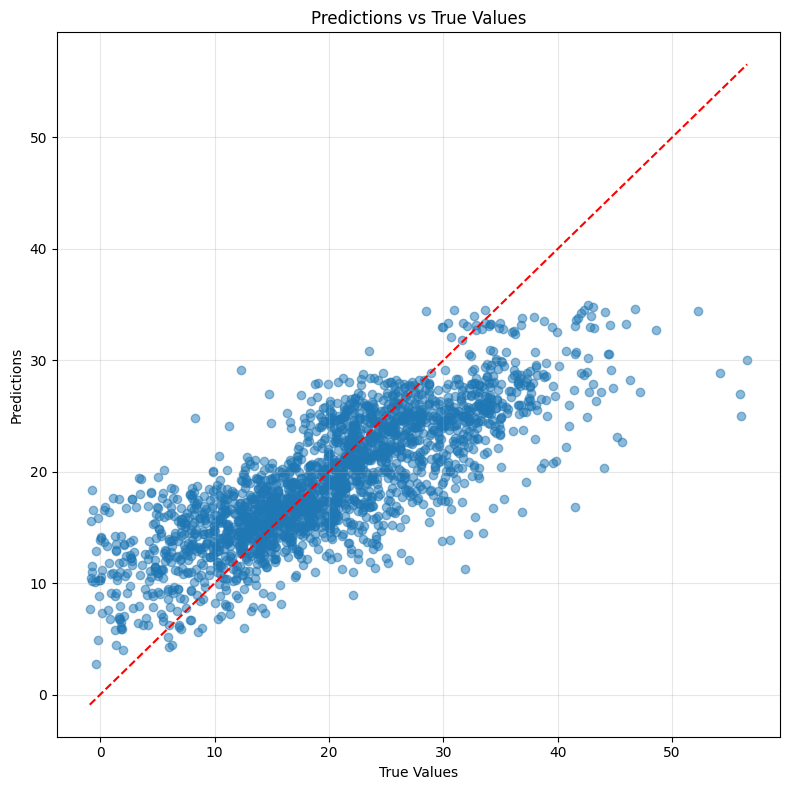

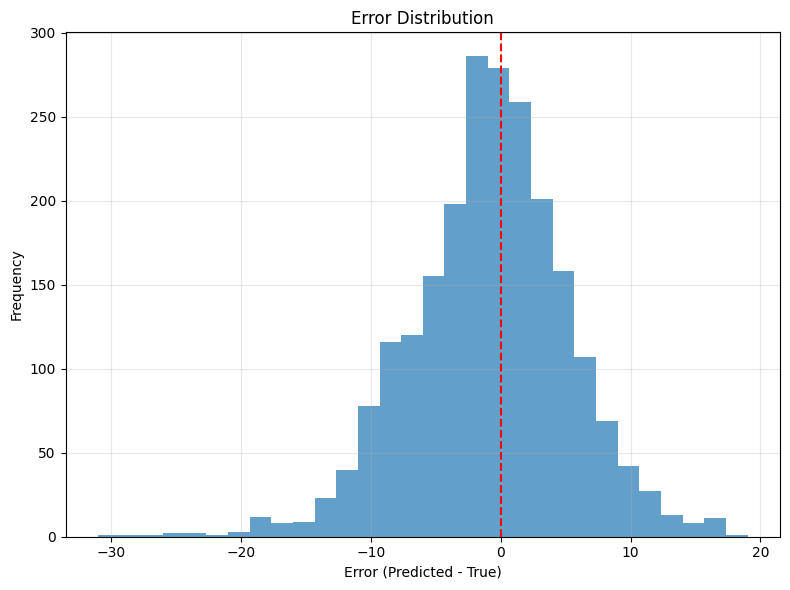

In [26]:
# Scatter plot of predictions vs true values
plt.figure(figsize=(8, 8))
plt.scatter(y_true_original, y_pred_original, alpha=0.5)
min_val = min(np.min(y_true_original), np.min(y_pred_original))
max_val = max(np.max(y_true_original), np.max(y_pred_original))
plt.plot([min_val, max_val], [min_val, max_val], 'r--')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Predictions vs True Values')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(RUN_DIR, 'predictions_plot.png'), dpi=300)
plt.show()

# Histogram of errors
errors = y_pred_original - y_true_original
plt.figure(figsize=(8, 6))
plt.hist(errors, bins=30, alpha=0.7)
plt.axvline(x=0, color='r', linestyle='--')
plt.xlabel('Error (Predicted - True)')
plt.ylabel('Frequency')
plt.title('Error Distribution')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(RUN_DIR, 'error_histogram.png'), dpi=300)
plt.show()